In [1]:
import pandas as pd

df_songs = pd.read_csv("billboard/Billboard Charts/hot100.csv", sep="\t")
df_songs

,date,title,artist,peakPos,lastPos,weeks,rank
0,2018-08-25,In My Feelings,Drake,1,1,7,1
1,2018-08-25,Girls Like You,Maroon 5 Featuring Cardi B,2,2,12,2
2,2018-08-25,I Like It,"Cardi B, Bad Bunny & J Balvin",1,3,19,3
3,2018-08-25,FEFE,6ix9ine Featuring Nicki Minaj & Murda Beatz,3,5,4,4
4,2018-08-25,Better Now,Post Malone,5,6,16,5
...,...,...,...,...,...,...,...
313395,1958-08-11,Down In Virginia,Jimmy Reed,96,0,0,96
313396,1958-08-11,Sunday Barbecue,Tennessee Ernie Ford,97,0,0,97
313397,1958-08-11,Gotta Have Rain,Eydie Gorme,74,74,2,98
313398,1958-08-11,Nothing In The World,Nat King Cole,99,0,0,99


In [2]:
def process_artists(input_str):
    liste_art = input_str.split()

    outp_list = []
    current_art = ""
    for art in liste_art:
        if art == "&" and current_art != "":
            outp_list.append(current_art)
            current_art = ""
        elif (art == "Featuring" or art == "featuring" or art == "Feat.") and current_art != "":
            outp_list.append(current_art)
            current_art = ""
        elif "," in art and art[len(art)-1] == ",":
            outp_list.append(current_art + " " + art[:-1])
            current_art = ""
        elif current_art == "":
            current_art = art
        else:
            current_art = current_art + " " + art

    if current_art:  # Append the last artist if there's any remaining
        outp_list.append(current_art)

    return outp_list

In [3]:
df_songs['artist'] = df_songs['artist'].apply(process_artists)
df_songs

,date,title,artist,peakPos,lastPos,weeks,rank
0,2018-08-25,In My Feelings,[Drake],1,1,7,1
1,2018-08-25,Girls Like You,"[Maroon 5, Cardi B]",2,2,12,2
2,2018-08-25,I Like It,"[Cardi B, Bad Bunny, J Balvin]",1,3,19,3
3,2018-08-25,FEFE,"[6ix9ine, Nicki Minaj, Murda Beatz]",3,5,4,4
4,2018-08-25,Better Now,[Post Malone],5,6,16,5
...,...,...,...,...,...,...,...
313395,1958-08-11,Down In Virginia,[Jimmy Reed],96,0,0,96
313396,1958-08-11,Sunday Barbecue,[Tennessee Ernie Ford],97,0,0,97
313397,1958-08-11,Gotta Have Rain,[Eydie Gorme],74,74,2,98
313398,1958-08-11,Nothing In The World,[Nat King Cole],99,0,0,99


In [4]:
all_artists_names = set(df_songs["artist"].iloc[0])
for art in df_songs["artist"].iloc[1:]:
    all_artists_names.update(art)
    
len(all_artists_names)

8432

In [5]:
import networkx as nx

G = nx.Graph()

for name_art_cur in all_artists_names:
    #artist_name = artists[name_art_cur]
    #artist_info = df_artists[df_artists["artist_id"] == name_art_cur]
    """if not artist_info.empty:  # Check if artist info exists
        popularity = int(artist_info['popularity'].iloc[0])
        followers = float(artist_info["followers"].iloc[0])
        # Filter out artists who are not successful
        #if popularity >= 70 and followers >= 1_000_000:
        G.add_node(name_art_cur, name=artist_name, popularity=popularity, followers=followers, genres=artist_info["genres"].iloc[0])
    else:
        print("Artist info not found for ID:", name_art_cur)"""
    G.add_node(name_art_cur)

for _, row in df_songs.iterrows():
    artist_name = list(row["artist"])
    # Filter out songs that do not have more than one artist in their execution
    if len(artist_name) > 1:
        for i in range(len(artist_name)):
            for j in range(i+1, len(artist_name)):
                artist_id_1 = artist_name[i]
                artist_id_2 = artist_name[j]
                # Check if the edge already exists
                if G.has_edge(artist_id_1, artist_id_2):
                    # If the edge already exists, increment the weight by 1
                    G[artist_id_1][artist_id_2]['weight'] += 1
                else:
                    # Add a new edge with weight 1
                    G.add_edge(artist_id_1, artist_id_2, weight=1) #song_id=row["song_id"], song_name=row["song_name"], explicit=row["explicit"], popularity=row["popularity"], release_date=row["release_date"], release_date_precision=row["release_date_precision"])
    else:
        artist_id = artist_name[0]
        # Model songs that do not have more than one artist in their execution as self-loops on the artist’s node
        if G.has_edge(artist_id, artist_id):
            # If the edge already exists, increment the weight by 1
            G[artist_id][artist_id]['weight'] += 1
        else:
            # Add a new edge with weight 1
            G.add_edge(artist_id, artist_id, weight=1)#, song_id=row["song_id"], song_name=row["song_name"], explicit=row["explicit"], popularity=row["popularity"], release_date=row["release_date"], release_date_precision=row["release_date_precision"])


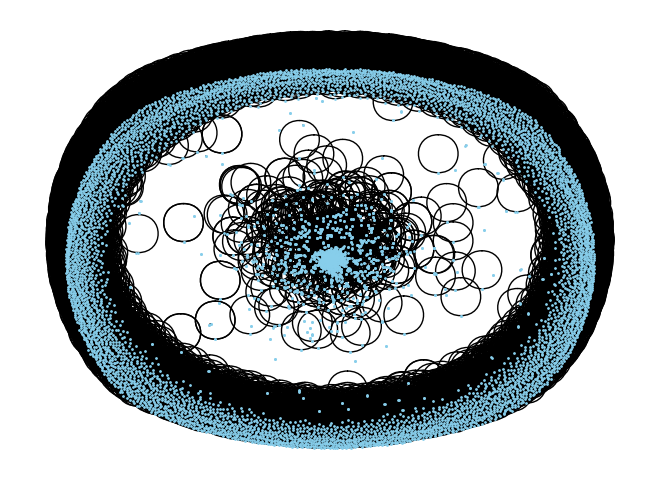

In [6]:
import matplotlib.pyplot as plt

# Draw the graph
nx.draw(G, with_labels=False, node_color='skyblue', node_size=1, edge_color='black', linewidths=1, font_size=15)

# Display the plot
plt.savefig("network.png")
plt.show()

## About the Network

comments:
- use names instead
- use other direction
- use only popular artists


In [7]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)


Number of nodes: 8432
Number of edges: 10614


In [8]:
node_list = list(G.nodes())
edge_list = list(G.edges())
#print("List of nodes:", node_list)
#print("List of edges:", edge_list)

In [9]:
degree = G.degree()
print("Degree of nodes:", degree)


Degree of nodes: [('C-Side', 1), ('Gladstone', 2), ('Donny Hathaway', 3), ("D'Angelo", 5), ('Rockell', 2), ('Hurricane Smith', 2), ('Juvenile', 8), ('Alicia Bridges', 2), ('Del Reeves', 2), ('The Fleetwoods', 2), ('The T.S.U. Toronadoes', 2), ('Meek Mill', 26), ('The DeFranco Family', 1), ('Silver Convention', 2), ('Imajin', 1), ('Diddy - Dirty Money', 3), ('The Scaffold', 2), ("The Flavor Unit MC's", 2), ('Classic Example', 2), ('Enrique Iglesias With Usher', 1), ('Nutta Butta', 5), ('Carl Douglas', 2), ('Shelley Fabares', 2), ('Billy Storm', 2), ('Robin S.', 2), ('Reparata', 2), ('Foxx', 2), ('Red Skelton', 2), ('Mad Lion', 2), ("The Cryan' Shames", 2), ('Rozetta Johnson', 2), ('Ben Colder', 2), ('Charm', 2), ('Francis Lai And His Orchestra', 2), ('Richard Chamberlain', 2), ('The Farm', 2), ('Mandy Moore', 2), ('James', 4), ('The Presidents', 2), ('Stacie Orrico', 2), ('The Drivers', 1), ('Linda McCartney', 1), ('Reba McEntire Duet With Kelly Clarkson', 2), ('Bertha Tillman', 2), ('W

In [10]:
density = nx.density(G)
print("Graph density:", density)


Graph density: 0.00029860659259437644


## Calculate the Metrics


In [11]:
# (1) Interaction (degree and weighted degree)
# (a) Single artists collaboration
# Calculate degree for single artists
single_artist_degree = dict(G.degree())

# (b) Multi-artists collaboration
# Calculate weighted degree for multi-artists collaboration
multi_artist_degree = dict(G.degree(weight='weight'))

# (2) Distance (closeness and eccentricity)
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Calculate eccentricity
# Check if the graph is connected
if not nx.is_connected(G):
    # Get the connected components
    components = nx.connected_components(G)
    for component in components:
        # Create subgraphs for each connected component
        subgraph = G.subgraph(component)
        # Now, you can analyze each subgraph separately
        # For example, you can calculate metrics like degree centrality for each subgraph
        degree_centrality = nx.degree_centrality(subgraph)
        nx.set_node_attributes(G, degree_centrality, name='degree_centrality')
        print("Degree Centrality for component:", degree_centrality)
else:        
    eccentricity = nx.eccentricity(G)

# (3) Similarity (clustering coefficient)
# Calculate clustering coefficient
clustering_coefficient = nx.clustering(G)

# (4) Influence (betweenness and eigenvector)
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Calculate eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

Degree Centrality for component: {'C-Side': 0.0007363770250368188, "D'Angelo": 0.003681885125184094, ' Future': 0.003681885125184094, 'George Clinton': 0.0022091310751104565, 'Juvenile': 0.005891016200294551, 'Meek Mill': 0.01914580265095729, 'Costi': 0.0022091310751104565, 'Ice Cube': 0.009572901325478646, 'Tyrese': 0.004418262150220913, 'Imajin': 0.0007363770250368188, 'Diddy - Dirty Money': 0.0022091310751104565, 'Kalenna': 0.0007363770250368188, 'Mindless Behavior': 0.0007363770250368188, 'Remo': 0.0007363770250368188, 'RZA': 0.0014727540500736377, 'Pimp C And The Shocker': 0.0007363770250368188, 'Enrique Iglesias With Usher': 0.0007363770250368188, 'Nutta Butta': 0.003681885125184094, 'James Ingram': 0.003681885125184094, ' Wale': 0.005154639175257732, 'Eric Church': 0.003681885125184094, 'Ellie Goulding': 0.004418262150220913, 'Foxx': 0.0014727540500736377, 'Sam Martin': 0.0007363770250368188, 'Watt': 0.0022091310751104565, 'Duece Poppito': 0.0022091310751104565, ' Kyjuan': 0.002

In [12]:
# Add degree centrality as a node attribute
#nx.set_node_attributes(G, degree_centrality, name='degree_centrality')

# Add degree and weighted degree as node attributes
nx.set_node_attributes(G, single_artist_degree, name='degree')
nx.set_node_attributes(G, multi_artist_degree, name='weighted_degree')

# Add closeness centrality as a node attribute
nx.set_node_attributes(G, closeness_centrality, name='closeness_centrality')

# Add clustering coefficient as a node attribute
nx.set_node_attributes(G, clustering_coefficient, name='clustering_coefficient')

# Add betweenness centrality as a node attribute
nx.set_node_attributes(G, betweenness_centrality, name='betweenness_centrality')

# Add eigenvector centrality as a node attribute
nx.set_node_attributes(G, eigenvector_centrality, name='eigenvector_centrality')


## Clustering


now try clustering based on metrics:

In [13]:
import pandas as pd

# Assuming G is your NetworkX graph

# Extract nodes and their attributes from the graph
nodes_with_attributes = [(node, G.nodes[node]) for node in G.nodes()]

# Create a DataFrame from the nodes and their attributes
df_nodes = pd.DataFrame(nodes_with_attributes, columns=['Node', 'Attributes'])

# Normalize the 'Attributes' column to expand it into separate columns
df_attributes = pd.json_normalize(df_nodes['Attributes'])

# Combine the original 'Node' column with the expanded attributes
df_nodes = pd.concat([df_nodes['Node'], df_attributes], axis=1)

# Display the DataFrame
df_nodes


,Node,degree_centrality,degree,weighted_degree,closeness_centrality,clustering_coefficient,betweenness_centrality,eigenvector_centrality
0,C-Side,0.000736,1,7,0.033605,0.0,0.000000,8.742311e-04
1,Gladstone,1.000000,2,22,0.000000,0.0,0.000000,1.989565e-13
2,Donny Hathaway,0.750000,3,87,0.000211,0.0,0.000000,1.541338e-10
3,D'Angelo,0.003682,5,171,0.030258,0.0,0.000061,9.684862e-05
4,Rockell,1.000000,2,76,0.000000,0.0,0.000000,1.989565e-13
...,...,...,...,...,...,...,...,...
8427,Lee Hazlewood,0.250000,1,23,0.000190,0.0,0.000000,5.872395e-11
8428,The Music Explosion,1.000000,2,42,0.000000,0.0,0.000000,1.989565e-13
8429,The Velvelettes,1.000000,2,28,0.000000,0.0,0.000000,1.989565e-13
8430,T.G. Sheppard With Clint Eastwood,1.000000,2,12,0.000000,0.0,0.000000,1.989565e-13


In [14]:
df_attributes

,degree_centrality,degree,weighted_degree,closeness_centrality,clustering_coefficient,betweenness_centrality,eigenvector_centrality
0,0.000736,1,7,0.033605,0.0,0.000000,8.742311e-04
1,1.000000,2,22,0.000000,0.0,0.000000,1.989565e-13
2,0.750000,3,87,0.000211,0.0,0.000000,1.541338e-10
3,0.003682,5,171,0.030258,0.0,0.000061,9.684862e-05
4,1.000000,2,76,0.000000,0.0,0.000000,1.989565e-13
...,...,...,...,...,...,...,...
8427,0.250000,1,23,0.000190,0.0,0.000000,5.872395e-11
8428,1.000000,2,42,0.000000,0.0,0.000000,1.989565e-13
8429,1.000000,2,28,0.000000,0.0,0.000000,1.989565e-13
8430,1.000000,2,12,0.000000,0.0,0.000000,1.989565e-13


take a look at betweenness_centrality

normalize:

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df_nodes is your DataFrame
# Select only the columns to be normalized
columns_to_normalize = df_nodes.columns[1:]  # Exclude the first and last columns
data_to_normalize = df_nodes[columns_to_normalize]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(data_to_normalize)

# Replace the original data with the normalized values
df_nodes_norm = df_nodes.copy()
df_nodes_norm[columns_to_normalize] = normalized_data

# Print the updated DataFrame
df_nodes_norm


,Node,degree_centrality,degree,weighted_degree,closeness_centrality,clustering_coefficient,betweenness_centrality,eigenvector_centrality
0,C-Side,0.000000,0.000000,0.002048,0.629436,0.0,0.000000,2.996046e-03
1,Gladstone,0.333170,0.010989,0.007170,0.000000,0.0,0.000000,0.000000e+00
2,Donny Hathaway,0.249816,0.021978,0.029362,0.003950,0.0,0.000000,5.275447e-10
3,D'Angelo,0.000982,0.043956,0.058040,0.566745,0.0,0.019873,3.319065e-04
4,Rockell,0.333170,0.010989,0.025606,0.000000,0.0,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...
8427,Lee Hazlewood,0.083108,0.000000,0.007511,0.003555,0.0,0.000000,2.005689e-10
8428,The Music Explosion,0.333170,0.010989,0.013998,0.000000,0.0,0.000000,0.000000e+00
8429,The Velvelettes,0.333170,0.010989,0.009218,0.000000,0.0,0.000000,0.000000e+00
8430,T.G. Sheppard With Clint Eastwood,0.333170,0.010989,0.003756,0.000000,0.0,0.000000,0.000000e+00


In [16]:
#print max value for each coloumn
print("max values:")
print(df_nodes.iloc[:,1:].max())
print(df_nodes_norm.iloc[:,1:].max())

#print min value for each coloumn
print()
print("min values:")
print(df_nodes.iloc[:,1:].min())
print(df_nodes_norm.iloc[:,1:].min())

max values:
degree_centrality            3.000000
degree                      92.000000
weighted_degree           2930.000000
closeness_centrality         0.053389
clustering_coefficient       1.000000
betweenness_centrality       0.003084
eigenvector_centrality       0.291795
dtype: float64
degree_centrality         1.0
degree                    1.0
weighted_degree           1.0
closeness_centrality      1.0
clustering_coefficient    1.0
betweenness_centrality    1.0
eigenvector_centrality    1.0
dtype: float64

min values:
degree_centrality         7.363770e-04
degree                    1.000000e+00
weighted_degree           1.000000e+00
closeness_centrality      0.000000e+00
clustering_coefficient    0.000000e+00
betweenness_centrality    0.000000e+00
eigenvector_centrality    1.989565e-13
dtype: float64
degree_centrality         0.0
degree                    0.0
weighted_degree           0.0
closeness_centrality      0.0
clustering_coefficient    0.0
betweenness_centrality    0.0
e

1/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


2/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


4/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


5/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


6/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


7/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


9/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


10/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


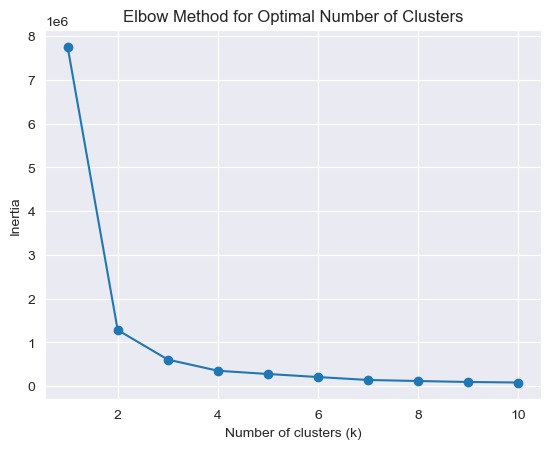

In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming df is your DataFrame with node attributes and edge attributes added

# Convert the DataFrame to a sparse adjacency matrix
A_dense = pairwise_distances(df_nodes_norm.iloc[:,1:], metric='euclidean')

# Apply Louvain community detection algorithm to detect communities (if needed)
# You may need to find an alternative community detection algorithm for DataFrame-based graphs

# Calculate the modularity for different values of k
k_values = range(1, 11)  # Adjust the range as needed
inertias = []

amount_k = len(k_values)
for k in k_values:
    print(f'{k}/{amount_k}')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(A_dense)
    inertia = kmeans.inertia_
    inertias.append(inertia)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The 

9/10
10/10


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


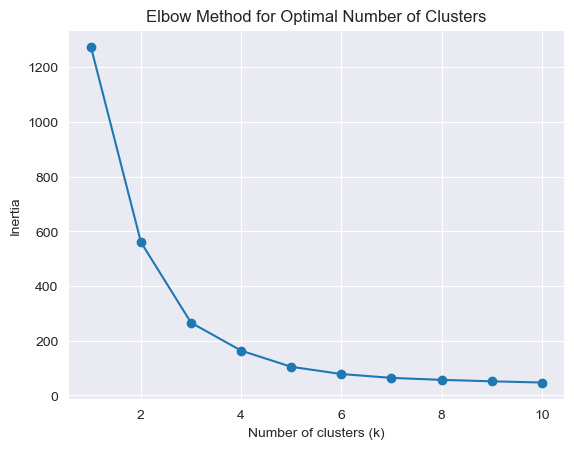

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming df is your DataFrame with node attributes and edge attributes added

# Convert the DataFrame to a sparse adjacency matrix
#A_dense = pairwise_distances(df_nodes.drop(columns=['Node']), metric='euclidean')
A_dense = df_nodes_norm.iloc[:,1:]

# Apply Louvain community detection algorithm to detect communities (if needed)
# You may need to find an alternative community detection algorithm for DataFrame-based graphs

# Calculate the modularity for different values of k
k_values = range(1, 11)  # Adjust the range as needed
inertias = []

amount_k = len(k_values)
for k in k_values:
    print(f'{k}/{amount_k}')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(A_dense)
    inertia = kmeans.inertia_
    inertias.append(inertia)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


for unnormalized the results were 3

In [19]:
from sklearn.cluster import KMeans

# Assuming df_nodes is your DataFrame containing node attributes

# Extract the features (attributes) from the DataFrame
X = df_nodes_norm.iloc[:,1:]

# Specify the number of clusters (k)
k = 3  # Adjust as needed

# Initialize KMeans model
kmeans = KMeans(n_clusters=k)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels as a new column in the DataFrame
df_nodes['Cluster'] = cluster_labels
df_nodes_norm['Cluster'] = cluster_labels

# Display the DataFrame with cluster labels
df_nodes


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Node,degree_centrality,degree,weighted_degree,closeness_centrality,clustering_coefficient,betweenness_centrality,eigenvector_centrality,Cluster
0,C-Side,0.000736,1,7,0.033605,0.0,0.000000,8.742311e-04,2
1,Gladstone,1.000000,2,22,0.000000,0.0,0.000000,1.989565e-13,0
2,Donny Hathaway,0.750000,3,87,0.000211,0.0,0.000000,1.541338e-10,0
3,D'Angelo,0.003682,5,171,0.030258,0.0,0.000061,9.684862e-05,2
4,Rockell,1.000000,2,76,0.000000,0.0,0.000000,1.989565e-13,0
...,...,...,...,...,...,...,...,...,...
8427,Lee Hazlewood,0.250000,1,23,0.000190,0.0,0.000000,5.872395e-11,0
8428,The Music Explosion,1.000000,2,42,0.000000,0.0,0.000000,1.989565e-13,0
8429,The Velvelettes,1.000000,2,28,0.000000,0.0,0.000000,1.989565e-13,0
8430,T.G. Sheppard With Clint Eastwood,1.000000,2,12,0.000000,0.0,0.000000,1.989565e-13,0


In [20]:
# Assuming df_nodes is your DataFrame with cluster labels

# Calculate the cardinality of each cluster
cluster_cardinality = df_nodes_norm['Cluster'].value_counts()

# Display the cardinality of each cluster
print(cluster_cardinality)


Cluster
0    6892
2    1006
1     534
Name: count, dtype: int64


In [21]:
##Dimensional reduction:

import pandas as pd
from sklearn.decomposition import PCA

# Assuming df is your DataFrame

# Omit the first and last columns
X = df_nodes_norm.iloc[:,1:-1]

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the data
X_2d = pca.fit_transform(X)

# Convert the result to a DataFrame
df_2d = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])

# Display the resulting DataFrame
df_2d["Node"] = df_nodes["Node"]
df_2d["Cluster"] = df_nodes["Cluster"]
df_2d

,Component 1,Component 2,Node,Cluster
0,0.438341,-0.408336,C-Side,2
1,-0.129551,0.004199,Gladstone,0
2,-0.090054,-0.029981,Donny Hathaway,0
3,0.399732,-0.384934,D'Angelo,2
4,-0.128909,0.003164,Rockell,0
...,...,...,...,...
8427,-0.020884,-0.088774,Lee Hazlewood,0
8428,-0.129313,0.003815,The Music Explosion,0
8429,-0.129480,0.004084,The Velvelettes,0
8430,-0.129670,0.004390,T.G. Sheppard With Clint Eastwood,0


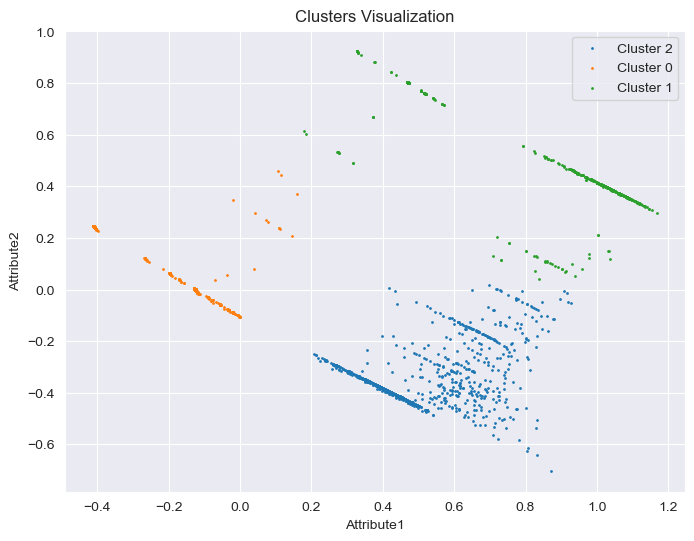

In [22]:
import matplotlib.pyplot as plt

# Assuming df_nodes is your DataFrame with cluster labels

# Plot the clusters in a scatter plot
plt.figure(figsize=(8, 6))

# Iterate over unique cluster labels
for cluster_label in df_2d['Cluster'].unique():
    # Filter the DataFrame for nodes in the current cluster
    df_cluster = df_2d[df_2d['Cluster'] == cluster_label]
    # Plot the nodes in the cluster
    plt.scatter(df_cluster["Component 1"], df_cluster["Component 2"], s=1, label=f'Cluster {cluster_label}')

# Add labels and title
plt.xlabel('Attribute1')
plt.ylabel('Attribute2')
plt.title('Clusters Visualization')

# Add legend
plt.legend()

# Show plot
plt.show()


In [23]:
radar_df = df_nodes_norm.copy()
features = radar_df.columns[1:-1]
print((features))
for feature in features:
    radar_df[feature] = (radar_df[feature] >= 0.5).astype(int)
    
radar_df

Index(['degree_centrality', 'degree', 'weighted_degree',
       'closeness_centrality', 'clustering_coefficient',
       'betweenness_centrality', 'eigenvector_centrality'],
      dtype='object')


,Node,degree_centrality,degree,weighted_degree,closeness_centrality,clustering_coefficient,betweenness_centrality,eigenvector_centrality,Cluster
0,C-Side,0,0,0,1,0,0,0,2
1,Gladstone,0,0,0,0,0,0,0,0
2,Donny Hathaway,0,0,0,0,0,0,0,0
3,D'Angelo,0,0,0,1,0,0,0,2
4,Rockell,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8427,Lee Hazlewood,0,0,0,0,0,0,0,0
8428,The Music Explosion,0,0,0,0,0,0,0,0
8429,The Velvelettes,0,0,0,0,0,0,0,0
8430,T.G. Sheppard With Clint Eastwood,0,0,0,0,0,0,0,0


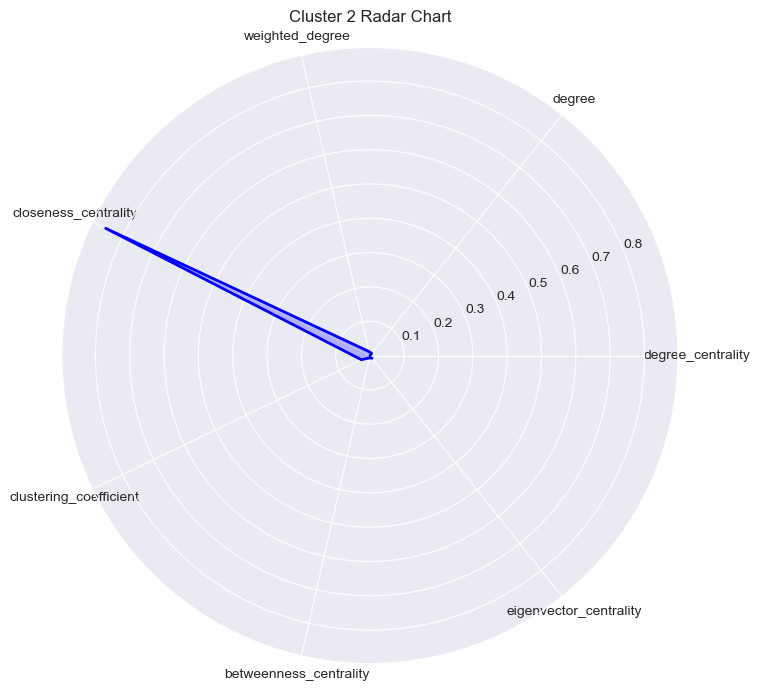

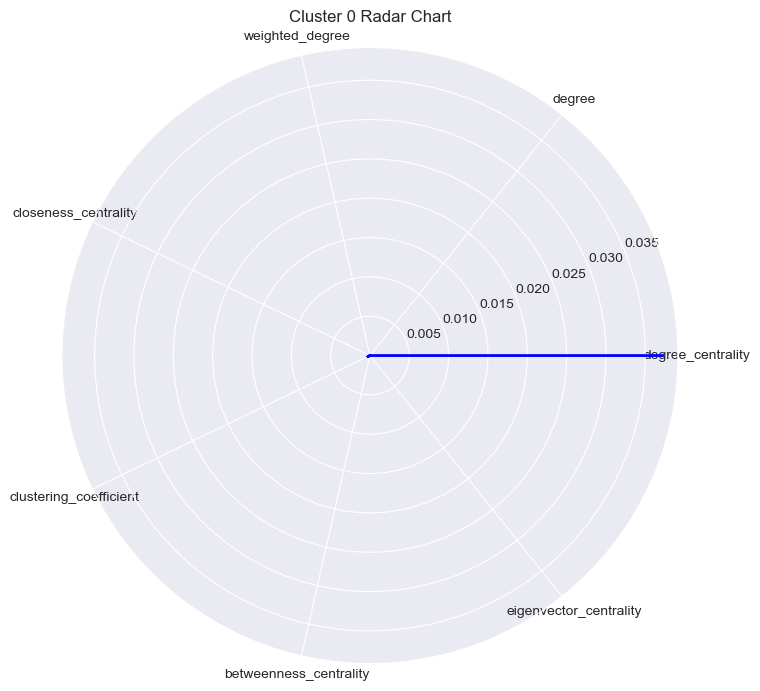

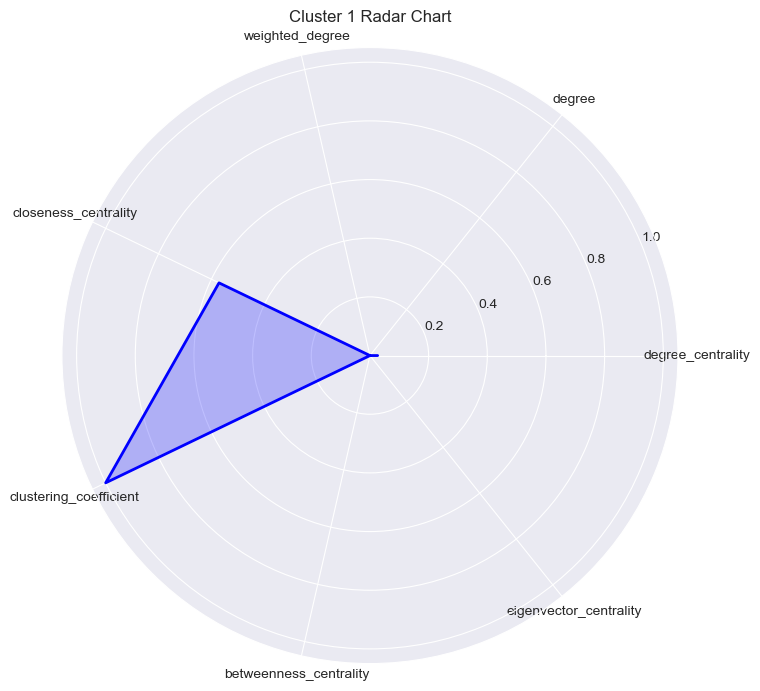

In [24]:
import numpy as np
import matplotlib.pyplot as plt

#for radar charts values to 1 if 0.5 or higher, rest to 0?
#######Profiles?##########

# Define the attributes for the radar chart
attributes = radar_df.iloc[:,1:-1].columns.tolist()

# Define the theta values (angles) for each attribute
theta = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False)

# Iterate over each unique cluster label
for cluster_label in radar_df['Cluster'].unique():
    # Create a figure and add a subplot with polar projection for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Filter the DataFrame for the current cluster
    cluster_data = radar_df[radar_df['Cluster'] == cluster_label]

    # Get attribute values for the current cluster
    values = cluster_data.iloc[:,1:-1].mean(axis=0).tolist()

    # Repeat the first value to close the plot
    #values += values[:1]

    # Plot the radar chart
    ax.fill(theta, values, color='blue', alpha=0.25)
    ax.plot(theta, values, color='blue', linewidth=2)

    # Set the labels for each attribute
    ax.set_xticks(theta)
    ax.set_xticklabels(attributes)

    # Set the title for the radar chart
    ax.set_title(f'Cluster {cluster_label} Radar Chart')

    # Show plot
    plt.show()


all makes more sense for not norm? 
=> take a look at init of graph and change?
=> not really successsfull


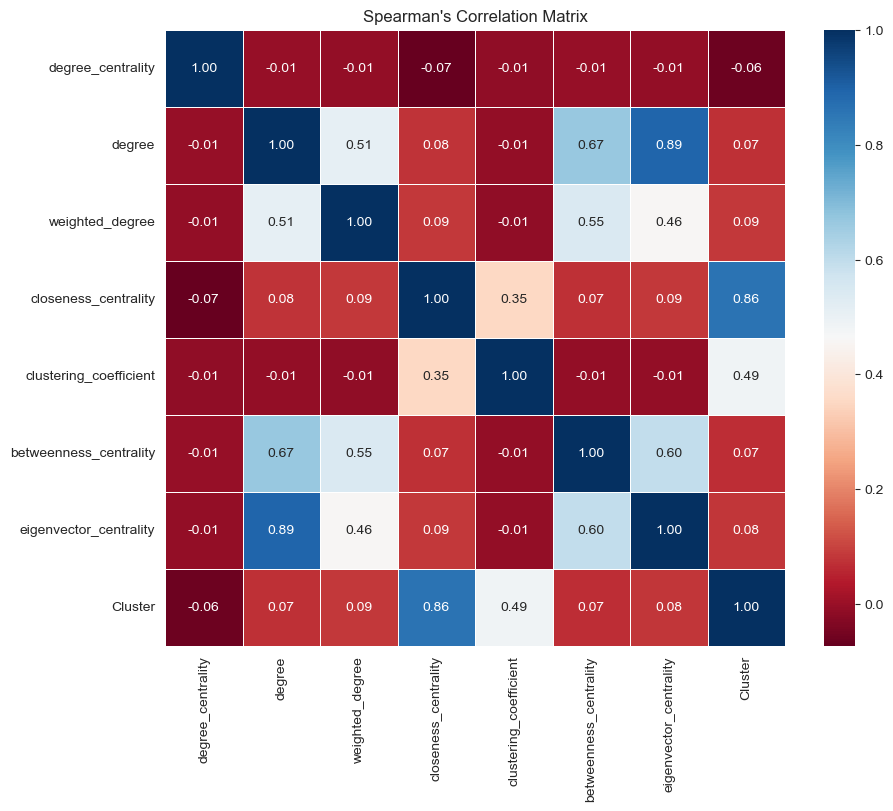

In [25]:
import seaborn as sns

# Compute Spearman's correlation matrix
corr_matrix = radar_df.iloc[:,1:].corr(method='spearman')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Matrix")
plt.show()


=> pca(5) then clustering?

ziemlich unterschiedlich zur vorlage???
versuche exakte Nachimplementierung

ValueError: Could not interpret value `followers` for `y`. An entry with this name does not appear in `data`.

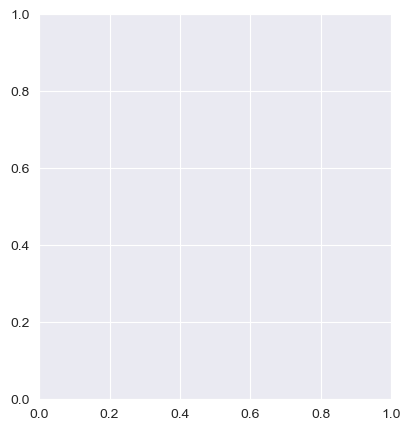

In [26]:
# Plot boxplots for followers and popularity per cluster
plt.figure(figsize=(10, 5))

# Boxplot for followers per cluster
plt.subplot(1, 2, 1)
sns.boxplot(x='Cluster', y='followers', data=df_nodes_norm)
plt.ylim(0, 30000000)
plt.title('Followers per Cluster')

# Boxplot for popularity per cluster
plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster', y='popularity', data=df_nodes_norm)
plt.title('Popularity per Cluster')

plt.tight_layout()
plt.show()

Abgrenzung ist nicht ganz so stark, allerdings dennoch substantiell, dies liegt vermutlich daran, dass wir alle genommen haben.

evtl Versuch nur als erfolgreich definierte zu nehmen.

Abgrenzung ist grundsätzlich nicht so stark für unnormalisiert, näher an Paper

## Density based Clustering:

In [27]:
df_nodes_norm

,Node,degree_centrality,degree,weighted_degree,closeness_centrality,clustering_coefficient,betweenness_centrality,eigenvector_centrality,Cluster
0,C-Side,0.000000,0.000000,0.002048,0.629436,0.0,0.000000,2.996046e-03,2
1,Gladstone,0.333170,0.010989,0.007170,0.000000,0.0,0.000000,0.000000e+00,0
2,Donny Hathaway,0.249816,0.021978,0.029362,0.003950,0.0,0.000000,5.275447e-10,0
3,D'Angelo,0.000982,0.043956,0.058040,0.566745,0.0,0.019873,3.319065e-04,2
4,Rockell,0.333170,0.010989,0.025606,0.000000,0.0,0.000000,0.000000e+00,0
...,...,...,...,...,...,...,...,...,...
8427,Lee Hazlewood,0.083108,0.000000,0.007511,0.003555,0.0,0.000000,2.005689e-10,0
8428,The Music Explosion,0.333170,0.010989,0.013998,0.000000,0.0,0.000000,0.000000e+00,0
8429,The Velvelettes,0.333170,0.010989,0.009218,0.000000,0.0,0.000000,0.000000e+00,0
8430,T.G. Sheppard With Clint Eastwood,0.333170,0.010989,0.003756,0.000000,0.0,0.000000,0.000000e+00,0


In [28]:
from sklearn.cluster import DBSCAN

# Assuming df_nodes is your DataFrame containing node attributes

# Extract the features (attributes) from the DataFrame
X = df_nodes_norm.iloc[:, 1:-1]  # Assuming your features start from column index 5

# Initialize DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed

# Fit the model to the data
dbscan.fit(X)

# Get the cluster labels
cluster_labels = dbscan.labels_

# Add cluster labels as a new column in the DataFrame
df_nodes['Cluster'] = cluster_labels
df_nodes_norm['Cluster'] = cluster_labels

# Display the DataFrame with cluster labels
df_nodes


,Node,degree_centrality,degree,weighted_degree,closeness_centrality,clustering_coefficient,betweenness_centrality,eigenvector_centrality,Cluster
0,C-Side,0.000736,1,7,0.033605,0.0,0.000000,8.742311e-04,0
1,Gladstone,1.000000,2,22,0.000000,0.0,0.000000,1.989565e-13,0
2,Donny Hathaway,0.750000,3,87,0.000211,0.0,0.000000,1.541338e-10,0
3,D'Angelo,0.003682,5,171,0.030258,0.0,0.000061,9.684862e-05,0
4,Rockell,1.000000,2,76,0.000000,0.0,0.000000,1.989565e-13,0
...,...,...,...,...,...,...,...,...,...
8427,Lee Hazlewood,0.250000,1,23,0.000190,0.0,0.000000,5.872395e-11,0
8428,The Music Explosion,1.000000,2,42,0.000000,0.0,0.000000,1.989565e-13,0
8429,The Velvelettes,1.000000,2,28,0.000000,0.0,0.000000,1.989565e-13,0
8430,T.G. Sheppard With Clint Eastwood,1.000000,2,12,0.000000,0.0,0.000000,1.989565e-13,0


In [29]:
# Assuming df_nodes is your DataFrame with cluster labels

# Calculate the cardinality of each cluster
cluster_cardinality = df_nodes_norm['Cluster'].value_counts()

# Display the cardinality of each cluster
print(cluster_cardinality)


Cluster
0    8432
Name: count, dtype: int64


In [30]:
##Dimensional reduction:

import pandas as pd
from sklearn.decomposition import PCA

# Assuming df is your DataFrame

# Omit the first and last columns
X = df_nodes_norm.iloc[:,1:-1]

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the data
X_2d = pca.fit_transform(X)

# Convert the result to a DataFrame
df_2d = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])

# Display the resulting DataFrame
df_2d["Node"] = df_nodes["Node"]
df_2d["Cluster"] = df_nodes["Cluster"]
df_2d

,Component 1,Component 2,Node,Cluster
0,0.438341,-0.408336,C-Side,0
1,-0.129551,0.004199,Gladstone,0
2,-0.090054,-0.029981,Donny Hathaway,0
3,0.399732,-0.384934,D'Angelo,0
4,-0.128909,0.003164,Rockell,0
...,...,...,...,...
8427,-0.020884,-0.088774,Lee Hazlewood,0
8428,-0.129313,0.003815,The Music Explosion,0
8429,-0.129480,0.004084,The Velvelettes,0
8430,-0.129670,0.004390,T.G. Sheppard With Clint Eastwood,0


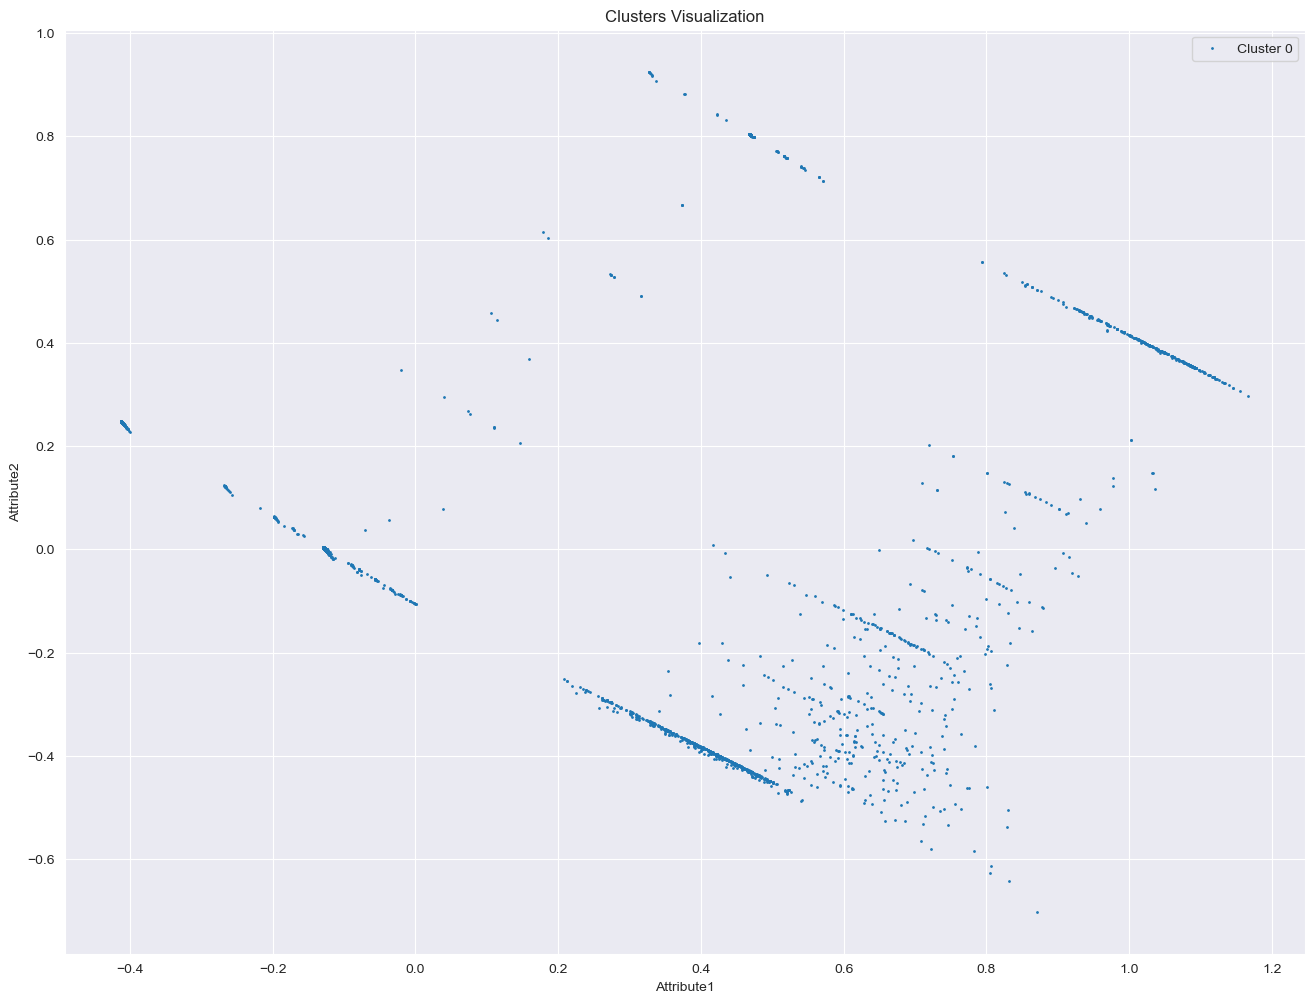

In [31]:
import matplotlib.pyplot as plt

# Assuming df_nodes is your DataFrame with cluster labels

# Plot the clusters in a scatter plot
plt.figure(figsize=(16, 12))

# Iterate over unique cluster labels
for cluster_label in df_2d['Cluster'].unique():
    # Filter the DataFrame for nodes in the current cluster
    df_cluster = df_2d[df_2d['Cluster'] == cluster_label]
    # Plot the nodes in the cluster
    plt.scatter(df_cluster["Component 1"], df_cluster["Component 2"], s=1, label=f'Cluster {cluster_label}')

# Add labels and title
plt.xlabel('Attribute1')
plt.ylabel('Attribute2')
plt.title('Clusters Visualization')

# Add legend
plt.legend()

# Show plot
plt.show()


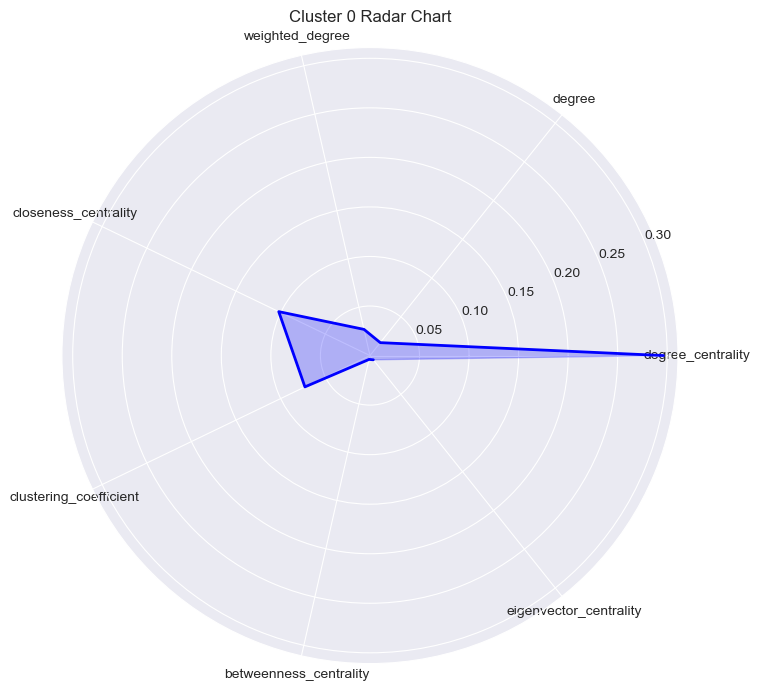

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define the attributes for the radar chart
attributes = df_nodes_norm.iloc[:,1:-1].columns.tolist()

# Define the theta values (angles) for each attribute
theta = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False)

# Iterate over each unique cluster label
for cluster_label in df_nodes_norm['Cluster'].unique():
    # Create a figure and add a subplot with polar projection for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Filter the DataFrame for the current cluster
    cluster_data = df_nodes_norm[df_nodes_norm['Cluster'] == cluster_label]

    # Get attribute values for the current cluster
    values = cluster_data.iloc[:,1:-1].mean(axis=0).tolist()

    # Repeat the first value to close the plot
    #values += values[:1]

    # Plot the radar chart
    ax.fill(theta, values, color='blue', alpha=0.25)
    ax.plot(theta, values, color='blue', linewidth=2)

    # Set the labels for each attribute
    ax.set_xticks(theta)
    ax.set_xticklabels(attributes)

    # Set the title for the radar chart
    ax.set_title(f'Cluster {cluster_label} Radar Chart')

    # Show plot
    plt.show()


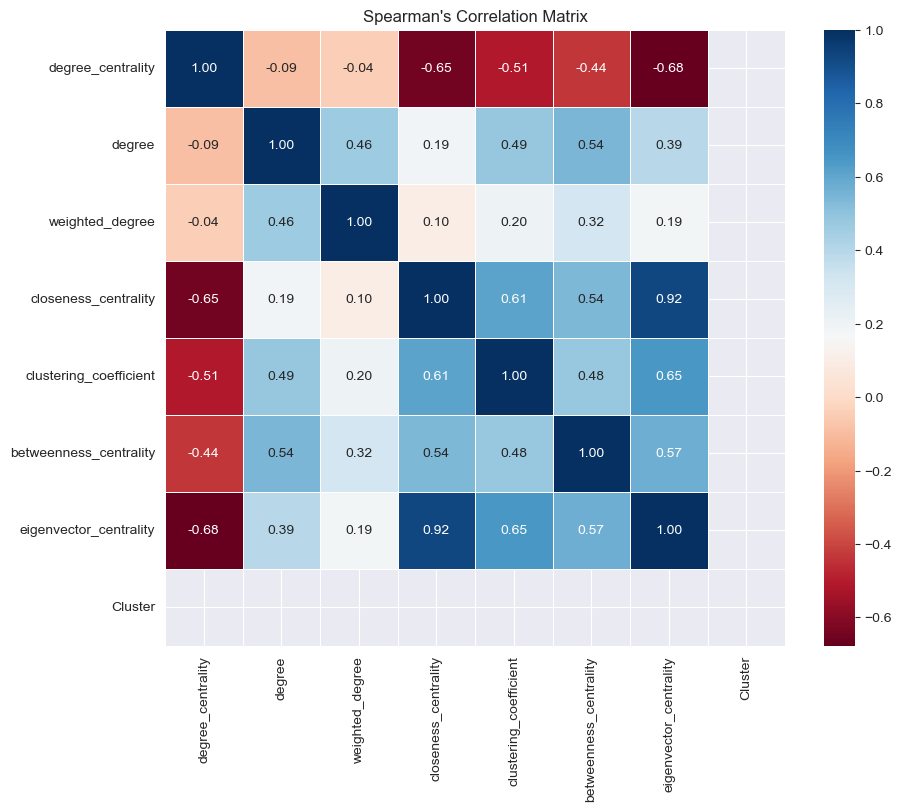

In [33]:
import seaborn as sns

# Compute Spearman's correlation matrix
corr_matrix = df_nodes.iloc[:,1:].corr(method='spearman') 

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Matrix")
plt.show()


ValueError: Could not interpret value `followers` for `y`. An entry with this name does not appear in `data`.

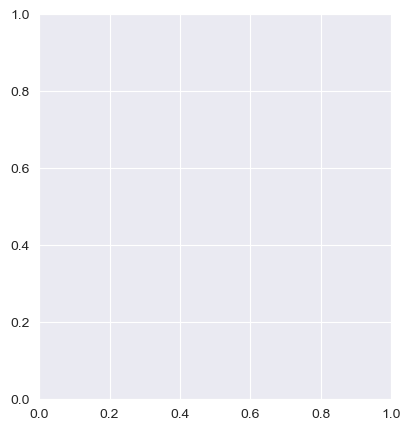

In [34]:
# Plot boxplots for followers and popularity per cluster
plt.figure(figsize=(10, 5))

# Boxplot for followers per cluster
plt.subplot(1, 2, 1)
sns.boxplot(x='Cluster', y='followers', data=df_nodes_norm)
plt.title('Followers per Cluster')

# Boxplot for popularity per cluster
plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster', y='popularity', data=df_nodes_norm)
plt.title('Popularity per Cluster')

plt.tight_layout()
plt.show()